## Imports

## Predição risco de credito

Este projeto tem como objetivo analisar os dados e criar modelos preditivos para previsão de risco de credito, visando reduzir o risco de perdas monetarias

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score,roc_curve, confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt
import seaborn as sns
import shap

In [2]:
# Carregar dataset
import os
data_path = os.path.join("assets", "dataset.csv")
df = pd.read_csv(data_path)
print(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dataset carregado com 1000 linhas e 21 colunas.


### Analise exploratória dos dados

Nessa seção, buscamos identificar valores ausentes e duplicados para que possamos trata-los.

Também procuramos por padrões e possiveis correções que possam melhorar a analise dos dados

Informações gerais, verificando se há presença de dados duplicados ou vazios

In [3]:
# Verificar tipos de dados e valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   id                                                        1000 non-null   int64 
 1   Duration in months                                        1000 non-null   int64 
 2   Credit history                                            1000 non-null   object
 3   Purpose of the credit                                     1000 non-null   object
 4   Credit amount                                             1000 non-null   int64 
 5   Status of savings account/bonds                           1000 non-null   object
 6   Present employment(years)                                 1000 non-null   object
 7   Installment rate in percentage of disposable income       1000 non-null   int64 
 8   personal_status              

In [4]:
# Verificar duplicados e valores nulos
print(f"valores nulos:\n{df.isna().sum()}")
print(f"\n\nvalores duplicados: {df.duplicated().sum()}")

valores nulos:
id                                                          0
Duration in months                                          0
Credit history                                              0
Purpose of the credit                                       0
Credit amount                                               0
Status of savings account/bonds                             0
Present employment(years)                                   0
Installment rate in percentage of disposable income         0
personal_status                                             0
Other debtors / guarantors                                  0
Present residence since X years                             0
Property                                                    0
Age in years                                                0
Other installment plans (banks/stores)                      0
Housing                                                     0
Number of existing credits at this bank                

Não ha dados duplicados nem valores vazios presentes no dataset.

In [5]:
# Exibir as 5 primeiras linhas para entender as colunas e os tipos de dados
print(df.head())

   id  Duration in months                  Credit history  \
0   1                   6  critical/other existing credit   
1   2                  48                   existing paid   
2   3                  12  critical/other existing credit   
3   4                  42                   existing paid   
4   5                  24              delayed previously   

  Purpose of the credit  Credit amount Status of savings account/bonds  \
0              radio/tv           1169                no known savings   
1              radio/tv           5951                            <100   
2             education           2096                            <100   
3   furniture/equipment           7882                            <100   
4               new car           4870                            <100   

  Present employment(years)  \
0                       >=7   
1                    1<=X<4   
2                    4<=X<7   
3                    4<=X<7   
4                    1<=X<4   

 

In [6]:
#removendo colunas irrelevantes
df = df.drop(columns=['id','Telephone'])
print(df.columns)

Index(['Duration in months', 'Credit history', 'Purpose of the credit',
       'Credit amount', 'Status of savings account/bonds',
       'Present employment(years)',
       'Installment rate in percentage of disposable income',
       'personal_status', 'Other debtors / guarantors',
       'Present residence since X years', 'Property', 'Age in years',
       'Other installment plans (banks/stores)', 'Housing',
       'Number of existing credits at this bank', 'Job',
       'Number of people being liable to provide maintenance for',
       'Foreign worker', 'Status of existing checking account'],
      dtype='object')


As colunas **Id** e **Telephone** foram removidas por não apresentarem valores relevantes para analise

Separando coluna de genero do estado civil, com o objetivo de identificar padrões mais especificos da influencia dessas caracteristicas

In [7]:
print(f"{df['personal_status']}")
print("\n\n------------------\n\n")
# Separando a coluna em duas
df[['genre', 'marital_state']] = df['personal_status'].str.split(' ', n=1, expand=True)

# Excluindo a coluna original
df = df.drop('personal_status', axis=1)

print(df[['genre', 'marital_state']])

0             male single
1      female div/dep/mar
2             male single
3             male single
4             male single
              ...        
995    female div/dep/mar
996          male div/sep
997           male single
998           male single
999           male single
Name: personal_status, Length: 1000, dtype: object


------------------


      genre marital_state
0      male        single
1    female   div/dep/mar
2      male        single
3      male        single
4      male        single
..      ...           ...
995  female   div/dep/mar
996    male       div/sep
997    male        single
998    male        single
999    male        single

[1000 rows x 2 columns]


In [8]:
#renomeando para facilitar leitura
df['marital_state']
df.loc[df['marital_state'] == 'div/dep/mar', 'marital_state'] = 'divorced / separated / married'
df.loc[df['marital_state'] == 'mar/wid', 'marital_state'] = 'married / widowed'
df.loc[df['marital_state'] == 'div/sep', 'marital_state'] = 'divorced / separated'

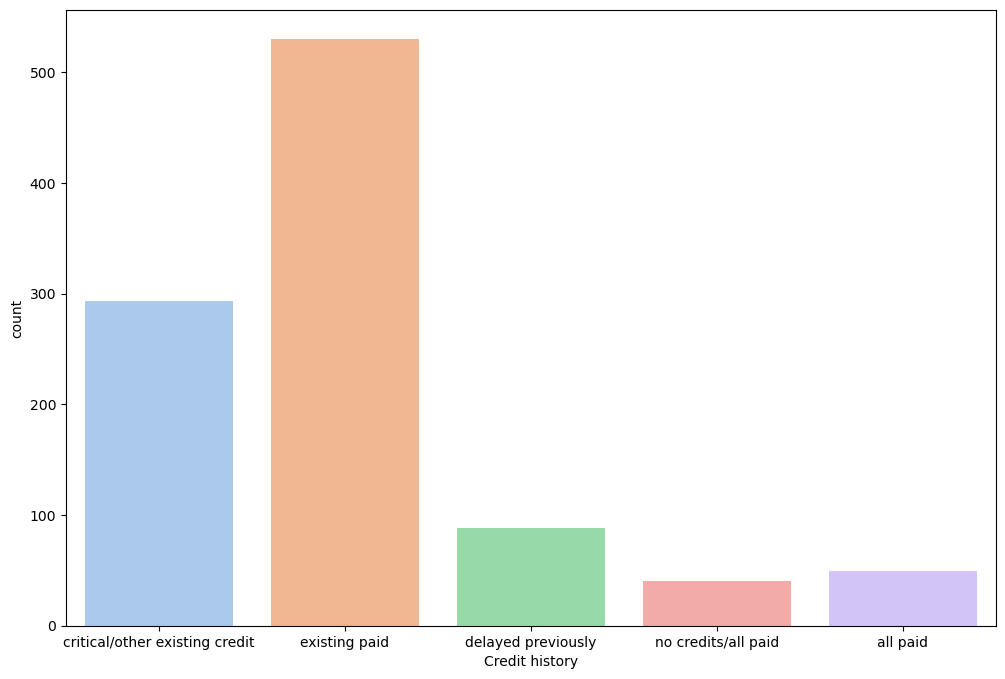

Credit history
existing paid                     0.530
critical/other existing credit    0.293
delayed previously                0.088
all paid                          0.049
no credits/all paid               0.040
Name: proportion, dtype: float64


In [9]:
plt.figure(figsize=(12,8))
sns.countplot(data=df, x="Credit history", hue="Credit history", palette="pastel", legend=False)
plt.show()
print(df['Credit history'].value_counts(normalize=True))

Credito finalizado ou pago corretamente:
- Credito existente e pago, 53%.
- totalmente pago, 4,9%.
- sem credito ou totalmente pago, 4%.
  
total: 61.9%

credito em outro banco:

29.3%

pagamento atrasado:

8.8%



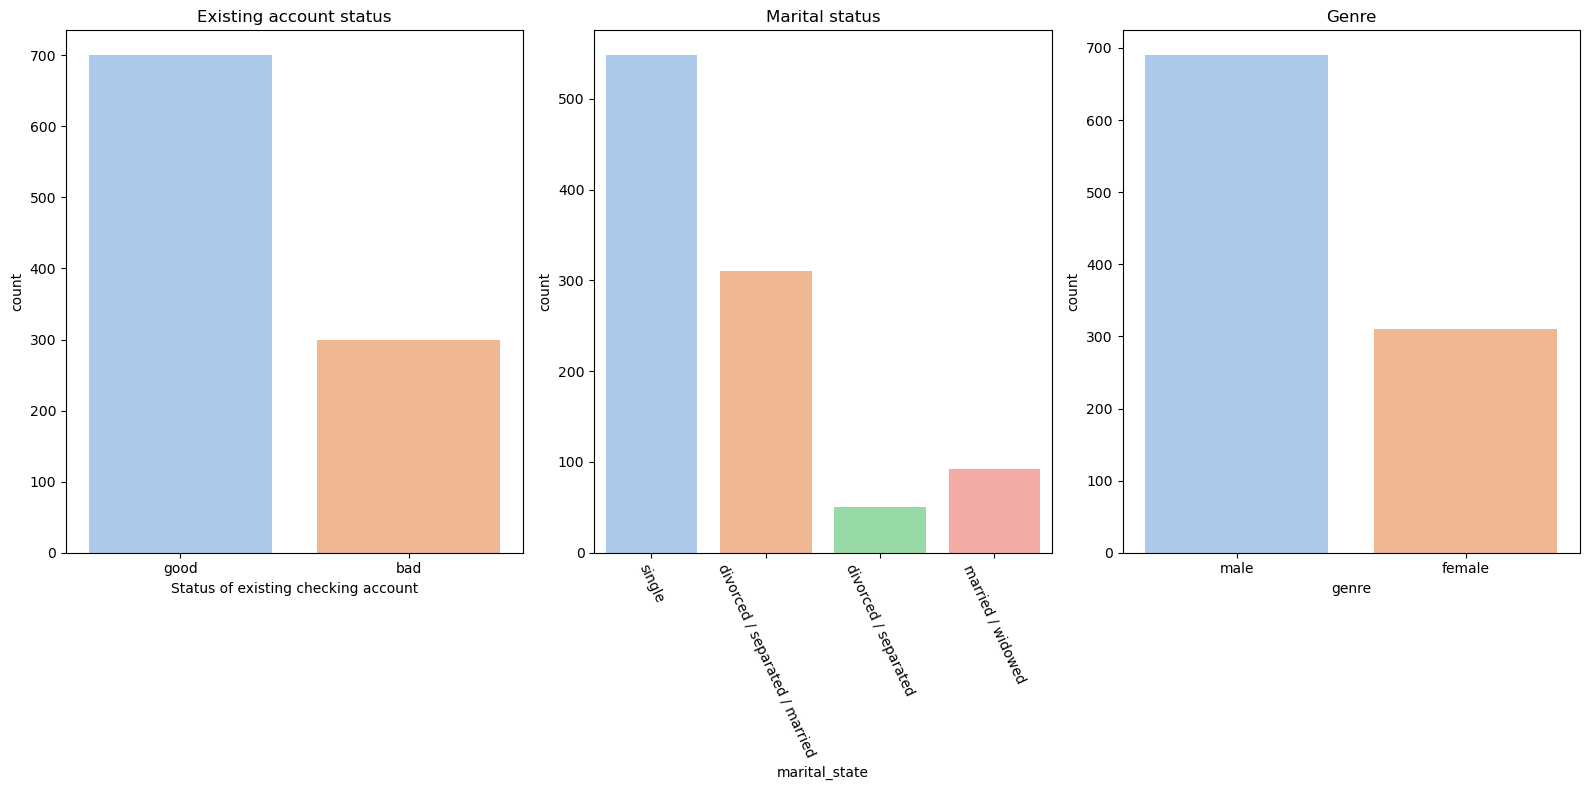

marital_state
single                            0.548
divorced / separated / married    0.310
married / widowed                 0.092
divorced / separated              0.050
Name: proportion, dtype: float64


Status of existing checking account
good    0.7
bad     0.3
Name: proportion, dtype: float64


genre
male      0.69
female    0.31
Name: proportion, dtype: float64


In [10]:
fig, axes = plt.subplots(1,3, figsize=(16,8))

sns.countplot(data=df, x="Status of existing checking account", hue="Status of existing checking account", palette="pastel", legend=False, ax=axes[0])
axes[0].set_title("Existing account status")
plt.tight_layout()

sns.countplot(data=df, x="marital_state", hue="marital_state", palette="pastel", legend=False, ax=axes[1])
axes[1].set_title("Marital status")
axes[1].tick_params(axis='x', rotation=-65)
plt.tight_layout()

sns.countplot(data=df, x="genre", hue="genre", palette="pastel", legend=False, ax=axes[2])
axes[2].set_title("Genre")
plt.tight_layout()


plt.show()

print(f"{df['marital_state'].value_counts(normalize=True)}")
print(f"\n\n{df['Status of existing checking account'].value_counts(normalize=True)}")
print(f"\n\n{df['genre'].value_counts(normalize=True)}")

No 1° grafico:
Pode-se perceber que os dados estão desbalanceados, 70% do dataset são bons pagadores e 30% não.

No 2° grafico:
Em sua maioria os clientes do dataset são solteiros, 54.8%

No 3° grafico:
Podemos ver que a maior parte do dataset é composto de pessoas do genero masculino, 69%

In [11]:
# verificar dados gerais do dataset
df.describe()

,Duration in months,Credit amount,Installment rate in percentage of disposable income,Present residence since X years,Age in years,Number of existing credits at this bank,Number of people being liable to provide maintenance for
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


Não há uma grande variância visível na maior parte às coluna, com exceção de "Duration in months", "credit amount" e "Age in years", que apresentam um salto entre o quartil de 75% e o seu maximo, podendo indicar presença de outliers


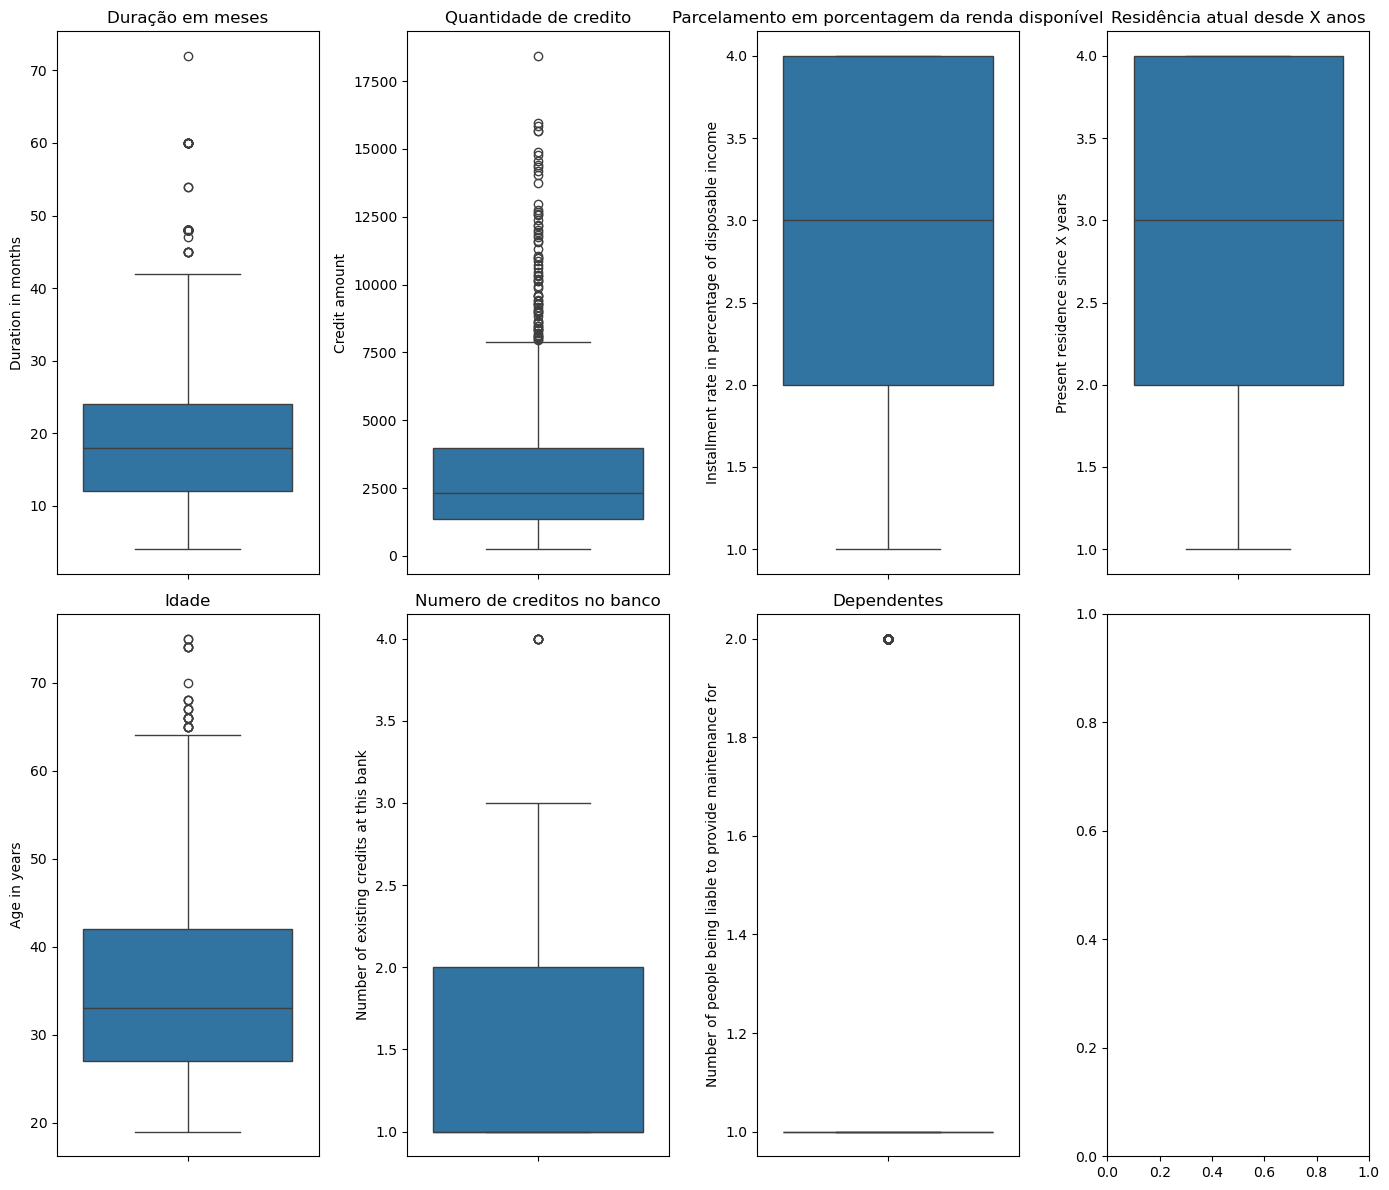

In [12]:
# criando grade de plots 
fig, axes = plt.subplots(2, 4, figsize=(14, 12))

# aplicando cada boxplot a sua respectiva posição

sns.boxplot(data=df, y="Duration in months", ax=axes[0][0])
axes[0][0].set_title("Duração em meses")
plt.tight_layout()

sns.boxplot(data=df, y="Credit amount", ax=axes[0][1])
axes[0][1].set_title("Quantidade de credito")
plt.tight_layout()

sns.boxplot(data=df, y="Installment rate in percentage of disposable income", ax=axes[0][2])
axes[0][2].set_title("Parcelamento em porcentagem da renda disponível")
plt.tight_layout()

sns.boxplot(data=df, y="Present residence since X years", ax=axes[0][3])
axes[0][3].set_title("Residência atual desde X anos")
plt.tight_layout()

sns.boxplot(data=df, y="Age in years", ax=axes[1][0])
axes[1][0].set_title("Idade")
plt.tight_layout()

sns.boxplot(data=df, y="Number of existing credits at this bank", ax=axes[1][1])
axes[1][1].set_title("Numero de creditos no banco")
plt.tight_layout()

sns.boxplot(data=df, y="Number of people being liable to provide maintenance for", ax=axes[1][2])
axes[1][2].set_title("Dependentes")
plt.tight_layout()



plt.show()

Podemos notar a presença de outliers em algumas colunas com base nos boxplots acima.

In [13]:
#função para contar numero de outliers presentes nas colunas
def count_outliers(df):
    outlier_counts = {}
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = outliers.shape[0]
    return pd.Series(outlier_counts, name='Outlier Count')

print(count_outliers(df))

Duration in months                                           70
Credit amount                                                72
Installment rate in percentage of disposable income           0
Present residence since X years                               0
Age in years                                                 23
Number of existing credits at this bank                       6
Number of people being liable to provide maintenance for    155
Name: Outlier Count, dtype: int64


In [14]:
# verificando valores da coluna
df['Number of people being liable to provide maintenance for'].value_counts()

Number of people being liable to provide maintenance for
1    845
2    155
Name: count, dtype: int64

Não ha uma grande quantidade de outliers nas colunas com exceção de "Credit amount" e "Duration in months". 

A coluna "Number of people being liable to provide maintenance for" apresenta apenas dois valores neste dataset: 1 e 2. Embora, ao aplicar métodos estatísticos tradicionais como o IQR (Interquartile Range), o valor 2 possa ser identificado como um outlier devido à sua menor frequência, ele representa aproximadamente 15,5% dos dados, o que configura uma proporção significativa.

Além disso, é importante destacar que esta variável não é necessariamente restrita aos valores 1 e 2 em seu domínio original, podendo assumir outros valores inteiros em diferentes contextos ou amostras.

Portanto, aplicar técnicas de remoção ou ajuste de outliers nesse caso poderia introduzir viés na análise ou nos modelos de machine learning, comprometendo a representatividade da variável.

Assim, opta-se por não realizar tratamento de outliers nessa coluna, respeitando sua natureza discreta e categórica no contexto atual dos dados.

In [15]:
#função para winsorização
def winsorize_series(series, lower_quantile=0.01, upper_quantile=0.99):
    lower = series.quantile(lower_quantile)
    upper = series.quantile(upper_quantile)
    return series.clip(lower=lower, upper=upper)

#winsorização - escala ampla com valores importantes
df['Credit amount'] = winsorize_series(df['Credit amount'])
df['Duration in months'] = winsorize_series(df['Duration in months'])

In [16]:
# verificando alterações nos outliers
print(count_outliers(df))

# validando alterações nos valores
df.describe()

Duration in months                                           70
Credit amount                                                72
Installment rate in percentage of disposable income           0
Present residence since X years                               0
Age in years                                                 23
Number of existing credits at this bank                       6
Number of people being liable to provide maintenance for    155
Name: Outlier Count, dtype: int64


,Duration in months,Credit amount,Installment rate in percentage of disposable income,Present residence since X years,Age in years,Number of existing credits at this bank,Number of people being liable to provide maintenance for
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.904000,3259.335200,2.973000,2.845000,35.546000,1.407000,1.155000
std,11.996612,2766.919812,1.118715,1.103718,11.375469,0.577654,0.362086
min,6.000000,425.830000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,60.000000,14180.390000,4.000000,4.000000,75.000000,4.000000,2.000000


A quantidade de outliers continua a mesma, porem ao aplicarmos a winsorização seus valores foram reduzidos consideravelmente

In [17]:
# one-hot enconde
df = pd.get_dummies(df)

In [18]:
# removendo colnas com valores de "sim" ou "não", com respostas ja presentes em outras

df = df.drop(columns=['Status of existing checking account_bad','Foreign worker_no'])

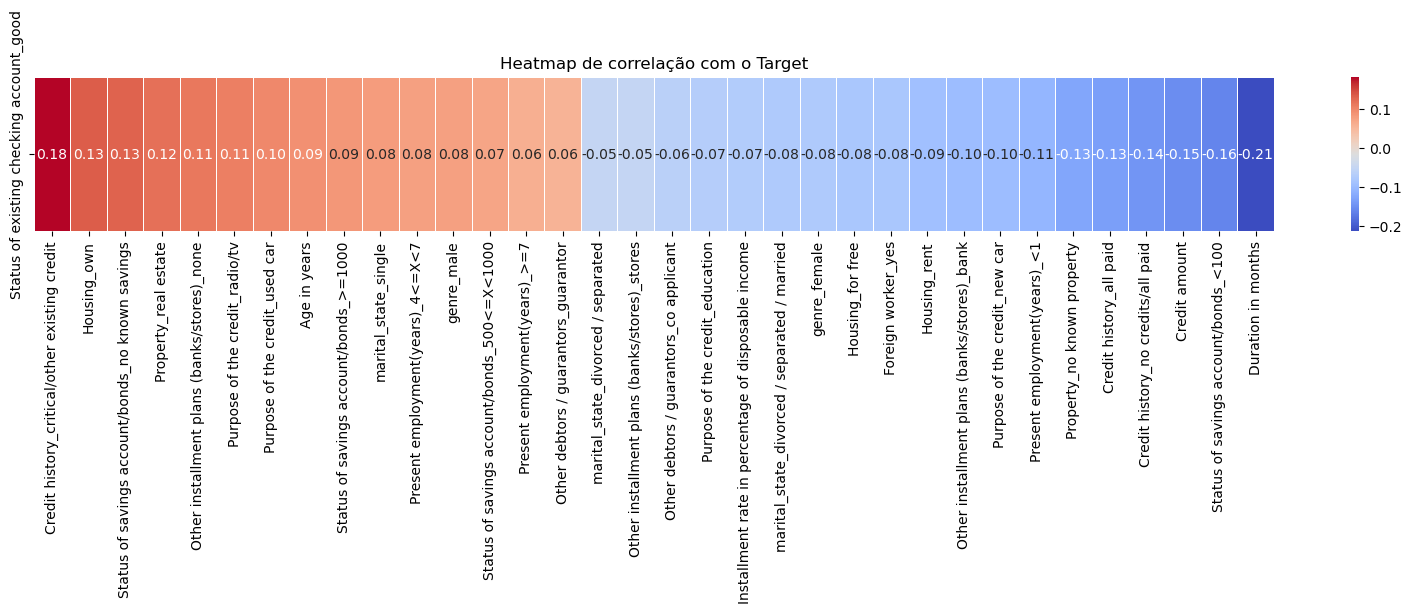

In [19]:
target = 'Status of existing checking account_good'

corr = df.corr()
corr_target = corr[target]

# Filtra: correlações maiores que 5%, exclui o próprio target
corr_target_filtered = corr_target[(abs(corr_target) >= 0.05) & (corr_target.index != target)]

# Ordena
corr_target_filtered = corr_target_filtered.sort_values(ascending=False)

# Converte para DataFrame 2D
corr_target_df = corr_target_filtered.to_frame().T  # Transposto para ter as variáveis no eixo X

plt.figure(figsize=(20, 2))  # Altura menor, pois é uma linha só
axis_corr = sns.heatmap(
    corr_target_df,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5
)

plt.title('Heatmap de correlação com o Target')

plt.show()


Podemos observar que as correlações mais relevantes são:
- Duração do crédito: correlação negativa.
- Possuir crédito em outro banco: correlação positiva.
- Status da conta de reserva < 100: correlação negativa.
- Quantidade de crédito do cliente: correlação negativa.

Considerando que a amostra de dados seja suficientemente grande para ser representativa da população, podemos inferir que a existência de crédito prévio no banco é um fator que influencia diretamente na decisão de concessão de crédito para o cliente.

Esse fator sugere que clientes que já possuem crédito podem ter uma maior probabilidade de obter novos créditos, enquanto variáveis como o montante e a duração do crédito tendem a impactar negativamente a decisão, possivelmente por estarem associadas a um maior risco de inadimplência.

### Treinamento do modelo

In [20]:
X = df.drop('Status of existing checking account_good', axis=1) # features
y = df['Status of existing checking account_good'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
# criando pipeline SMOTE
pipeline_SMOT = Pipeline([
    ('scaler',StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# criando pipeline nearmiss
pipeline_NM = Pipeline([
    ('scaler',StandardScaler()),
    ('near', NearMiss()),
    ('clf', RandomForestClassifier(random_state=42))
])

# preparando parametros dos modelos
param_grid = [
    {
        'clf':[RandomForestClassifier(random_state=42)],
        'clf__n_estimators': [100,200],
        'clf__max_depth': [None , 5, 10, 20],
        'clf__min_samples_split': [2,5],

    },
    {
        "clf":[DecisionTreeClassifier(random_state=42)],
        'clf__criterion':['gini','entropy','log_loss'],
        'clf__max_depth': [None , 5, 10, 20, 50],
        'clf__min_samples_split': [2,5,10],
        'clf__min_samples_leaf':[1,2,4],
    },
    {
        'clf':[LogisticRegression(max_iter=1000)],
        'clf__C':[0.1,1,10]
    },
    {
        'clf':[KNeighborsClassifier()],
        'clf__n_neighbors':list(range(1,31)),
        'clf__weights':['uniform','distance'],
        'clf__metric':['euclidean', 'manhattan', 'minkowski'],
    },
    {
        'clf':[GradientBoostingClassifier()],
        'clf__n_estimators': [100, 200],
        'clf__learning_rate': [0.05, 0.07, 0.1],
        'clf__max_depth': [3, 5, 7]
    }
]

# definindo metricas de avaliação
scoring = {
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision',
    'roc_auc': 'roc_auc'
}



Neste problema, as métricas mais relevantes são o Recall e a Precision, uma vez que desejamos equilibrar dois objetivos críticos: identificar corretamente os clientes inadimplentes (maximizando o Recall) e evitar a reprovação indevida de bons pagadores (maximizando a Precision). 

Dado esse cenário, foi selecionado o F1-Score como a principal métrica de avaliação, pois representa a média harmônica entre Precision e Recall, penalizando modelos que apresentam desempenho desequilibrado entre estas duas métricas.

In [22]:
# definindo parametros do GridSearch com SMOT
grid_search_st = GridSearchCV(pipeline_SMOT, param_grid, cv=5, scoring=scoring, refit='f1', n_jobs=-1)
grid_search_st.fit(X_train, y_train)


# definindo parametros do GridSearch com nearmiss
grid_search_nm = GridSearchCV(pipeline_NM, param_grid, cv=5, scoring=scoring, refit='f1', n_jobs=-1)
grid_search_nm.fit(X_train, y_train)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('near', NearMiss()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(random_state=42)],
                          'clf__max_depth': [None, 5, 10, 20],
                          'clf__min_samples_split': [2, 5],
                          'clf__n_estimators': [100, 200]},
                         {'clf': [DecisionTreeClassifier(random_state...
                          'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30],
                          'clf__weights': ['uniform', 'distance']},
                         {'clf': [GradientBoostingClassifier()],
                          'clf__learning_rate': [0.05, 0.07, 0.1],
                          'clf__max_depth': [3, 5, 7],
                          'clf__n_estimators': [100, 200]}],
             refit='f1',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

### Avaliação dos modelos

#### Comparação dos resultados do treinamento com NearMiss e SMOTE

In [23]:

'''
Recebe um objeto GridSearchCV, transforma os resultados em um DataFrame e adiciona o nome do modelo testado.
Para cada modelo, seleciona a melhor combinação de hiperparâmetros com base na métrica F1-score e cria gráficos de barras mostrando F1, Recall, Precision e ROC AUC.
Por fim, imprime as melhores combinações e métricas para análise detalhada de cada modelo.
'''

def avaliacao_grid_search(grid_search):
    # Transforma os resultados em DataFrame para facilitar a visualização
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Criar coluna com nome do modelo
    results_df['model_name'] = results_df['param_clf'].apply(lambda x: type(x).__name__)

    # Encontrar o melhor resultado de cada modelo
    best_per_model = results_df.loc[results_df.groupby('model_name')['mean_test_f1'].idxmax()]

    # Configurar o subplot 3x2 → 6 espaços (sobra 1)
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))
    axes = axes.flatten()  # Facilita iteração

    # Para cada modelo, criar um gráfico de barras
    for i, (idx, row) in enumerate(best_per_model.iterrows()):
        model = row['model_name']
        metrics = {
            'F1': row['mean_test_f1'],
            'Recall': row['mean_test_recall'],
            'Precision': row['mean_test_precision'],
            'ROC AUC': row['mean_test_roc_auc']
        }
        
        ax = axes[i]
        ax.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightgreen', 'salmon', 'orange'])
        ax.set_ylim(0, 1)
        ax.set_title(f'Métricas - {model}')
        ax.set_ylabel('Score')
        ax.set_xlabel('Métrica')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Se sobrar espaço, remover plot vazio
    if len(best_per_model) < len(axes):
        for j in range(len(best_per_model), len(axes)):
            fig.delaxes(axes[j])

    # Ajustar o layout para não sobrepor textos
    plt.tight_layout()
    plt.show()

    colum = best_per_model['model_name']
    for c in colum:
        # Filtrar apenas DecisionTree
        dt_results = results_df[results_df['model_name'] == c]

        # Encontrar o índice da melhor combinação (maior F1)
        best_idx = dt_results['mean_test_f1'].idxmax()

        #arvore de decisão
        print(f"Melhor combinação de hiperparâmetros para {c}:")
        print(results_df.loc[best_idx, 'params'])

        print("\nMétricas da melhor combinação:")
        print(f"F1: {results_df.loc[best_idx, 'mean_test_f1']:.4f}")
        print(f"Recall: {results_df.loc[best_idx, 'mean_test_recall']:.4f}")
        print(f"Precision: {results_df.loc[best_idx, 'mean_test_precision']:.4f}")
        print(f"ROC AUC: {results_df.loc[best_idx, 'mean_test_roc_auc']:.4f}\n")


def modeloTeste(grid_search):
    # executando modelo de predição com os dados de teste
    print('\nPrevisão com dados teste:\n')
    print(grid_search.best_estimator_)
    y_pred = grid_search.best_estimator_.predict(X_test)

    # salvando metricas
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    #exibindo valores
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    if hasattr(grid_search.best_estimator_, "predict_proba"):
        y_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"ROC AUC: {roc_auc:.4f}")


    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



#### SMOTE

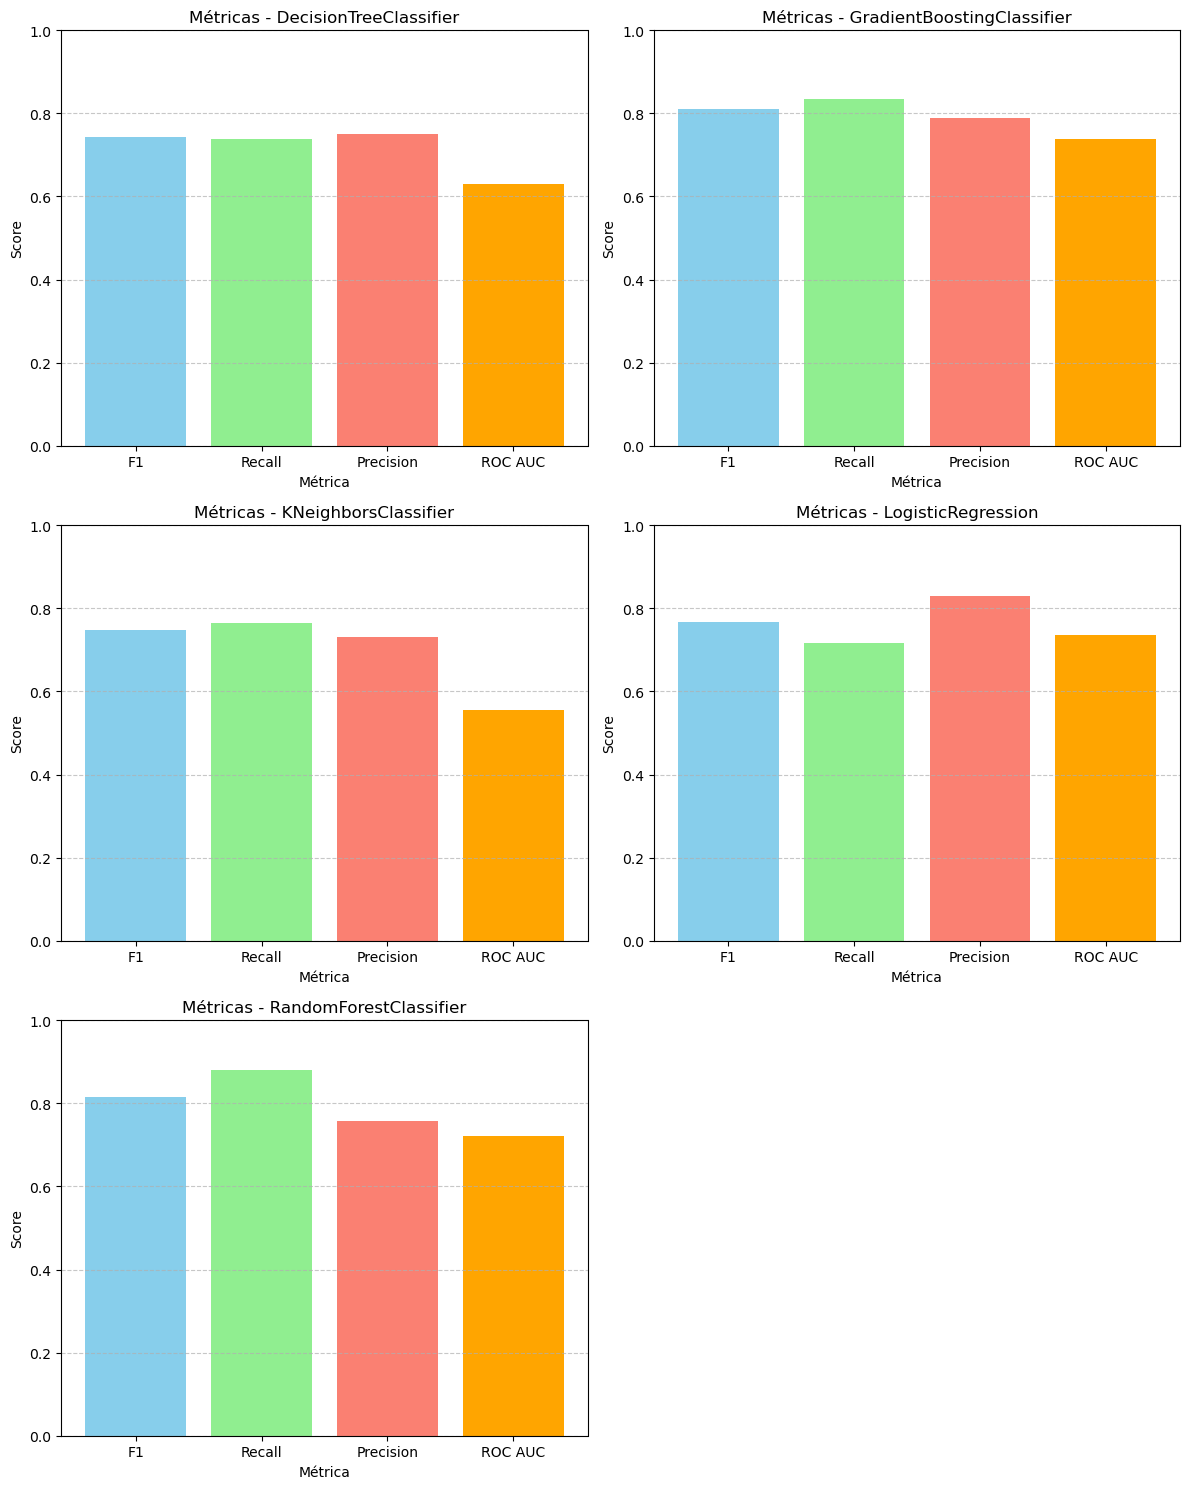

Melhor combinação de hiperparâmetros para DecisionTreeClassifier:
{'clf': DecisionTreeClassifier(random_state=42), 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}

Métricas da melhor combinação:
F1: 0.7428
Recall: 0.7375
Precision: 0.7499
ROC AUC: 0.6298

Melhor combinação de hiperparâmetros para GradientBoostingClassifier:
{'clf': GradientBoostingClassifier(), 'clf__learning_rate': 0.07, 'clf__max_depth': 3, 'clf__n_estimators': 100}

Métricas da melhor combinação:
F1: 0.8102
Recall: 0.8339
Precision: 0.7878
ROC AUC: 0.7392

Melhor combinação de hiperparâmetros para KNeighborsClassifier:
{'clf': KNeighborsClassifier(), 'clf__metric': 'manhattan', 'clf__n_neighbors': 1, 'clf__weights': 'uniform'}

Métricas da melhor combinação:
F1: 0.7474
Recall: 0.7643
Precision: 0.7316
ROC AUC: 0.5551

Melhor combinação de hiperparâmetros para LogisticRegression:
{'clf': LogisticRegression(max_iter=1000), 'clf__C': 0.1}

Métricas da melhor 

In [24]:
avaliacao_grid_search(grid_search_st)

Com o oversampling, SMOTE, tendo a metrica F1 como metrica principal, por ser uma relação entre precision e recall, os modelos que mais se destacaram foram: GradientBoosting (GB) **81%** e RandomForestClassifier (RF) **81.47%**.

O GradientBoosting apresentou um valor melhor para o **Precision** 78% GB e 75% RF, enquanto  RandomForestClassifier apresentou um valor melhor para **Recall** 88% RF e 83% GB

Dada a natureza do negocio, onde deve-se evitar falsos positivos e falsos negativos, um maior Recall se mostra a melhor opção

#### NearMiss

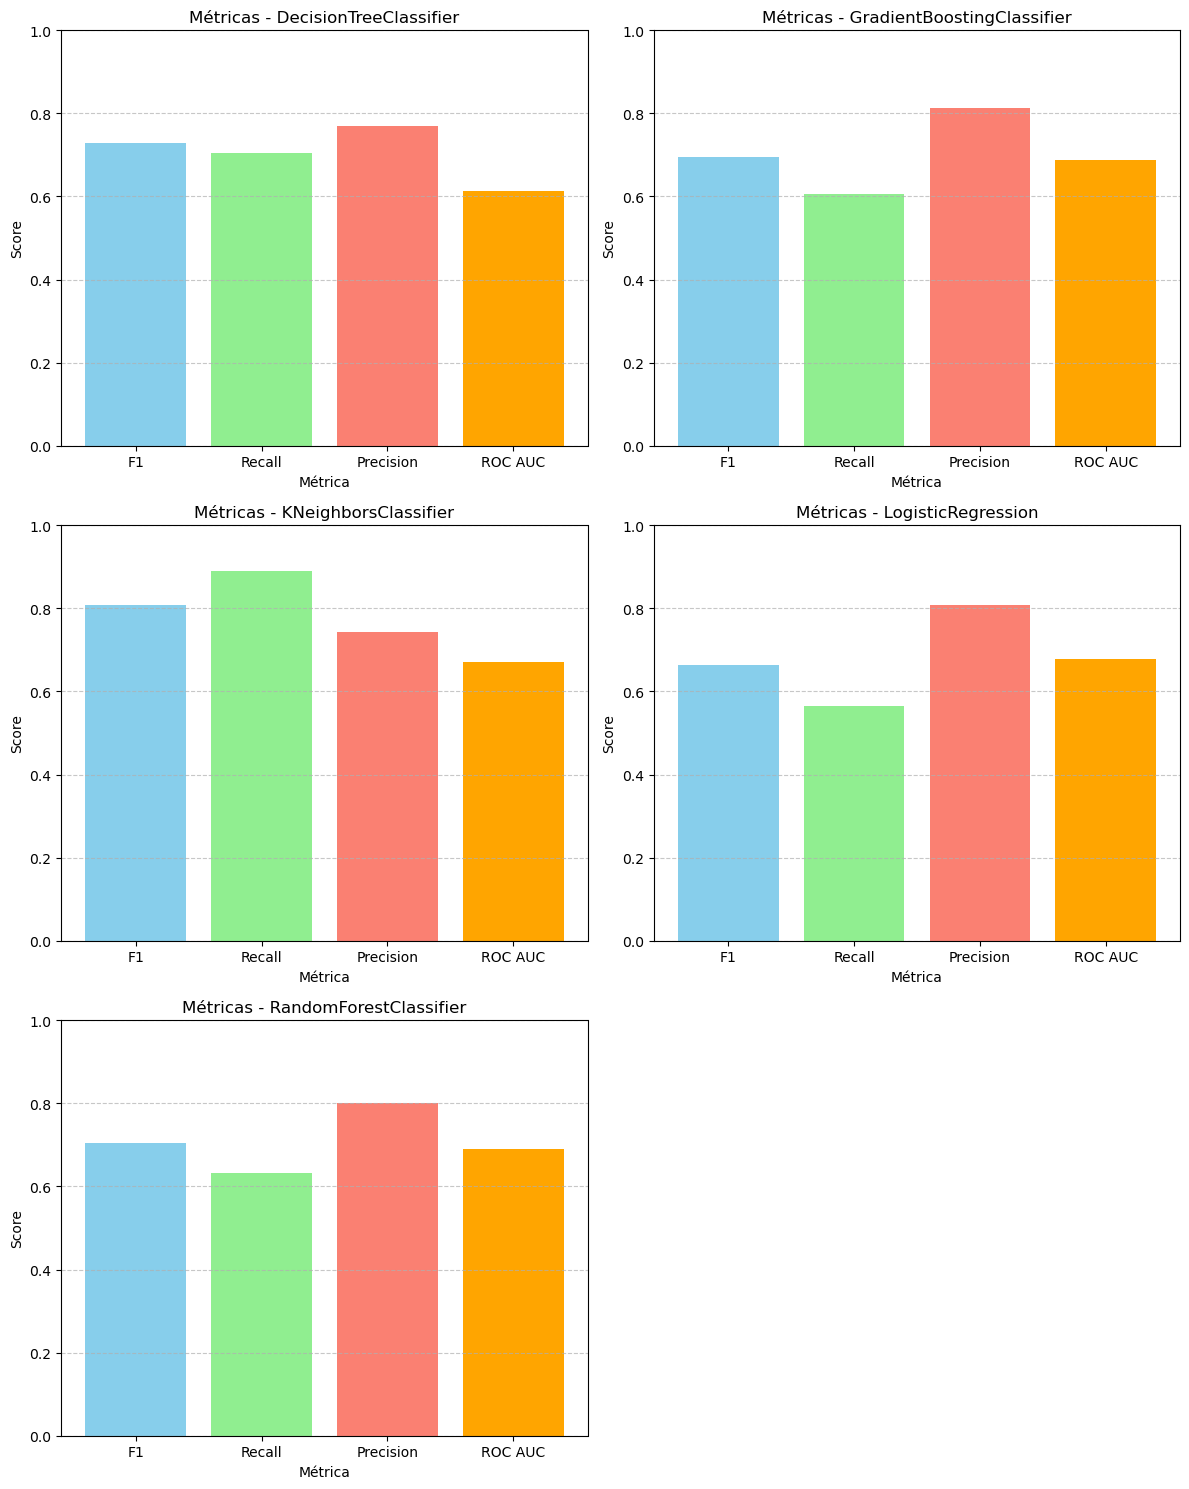

Melhor combinação de hiperparâmetros para DecisionTreeClassifier:
{'clf': DecisionTreeClassifier(random_state=42), 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}

Métricas da melhor combinação:
F1: 0.7295
Recall: 0.7036
Precision: 0.7704
ROC AUC: 0.6129

Melhor combinação de hiperparâmetros para GradientBoostingClassifier:
{'clf': GradientBoostingClassifier(), 'clf__learning_rate': 0.07, 'clf__max_depth': 3, 'clf__n_estimators': 100}

Métricas da melhor combinação:
F1: 0.6944
Recall: 0.6071
Precision: 0.8125
ROC AUC: 0.6866

Melhor combinação de hiperparâmetros para KNeighborsClassifier:
{'clf': KNeighborsClassifier(), 'clf__metric': 'euclidean', 'clf__n_neighbors': 30, 'clf__weights': 'distance'}

Métricas da melhor combinação:
F1: 0.8091
Recall: 0.8893
Precision: 0.7427
ROC AUC: 0.6705

Melhor combinação de hiperparâmetros para LogisticRegression:
{'clf': LogisticRegression(max_iter=1000), 'clf__C': 0.1}

Métricas da melhor

In [25]:
avaliacao_grid_search(grid_search_nm)

Com o NearMiss o modelo que apresentou os melhores resultados foi o KNeighborsClassifier com f1 de 80.9%.

Isso pode ocorrer devido a quantidade mais reduzidade de dados, gerando mais "proximidade" entre eles o que pode causar um melhor desempenho em modelos como KNN que se baseiam em proximodade para suas predioções, porém isso também é um agravante podendo gerar overfitting uma vez que o modelo se ajusta a uma quantidade de dados reduzida.


### Comparando KNN, GradientBoost e RandomForest

Comparando os tres modelos com os melhores resultados apresentados

Resultados do modelo:
RandomForestClassifier(min_samples_split=5, random_state=42)


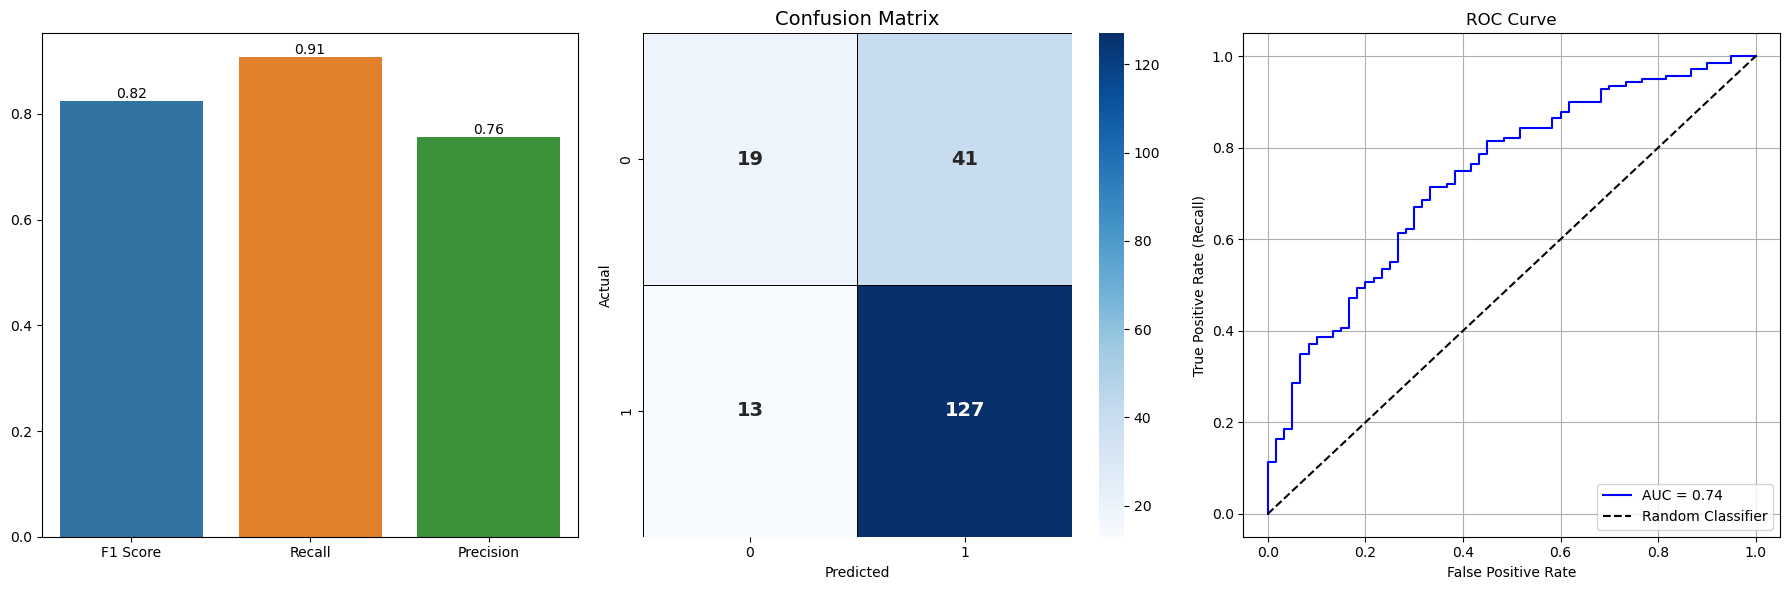




Resultados do modelo:
GradientBoostingClassifier(learning_rate=0.07)


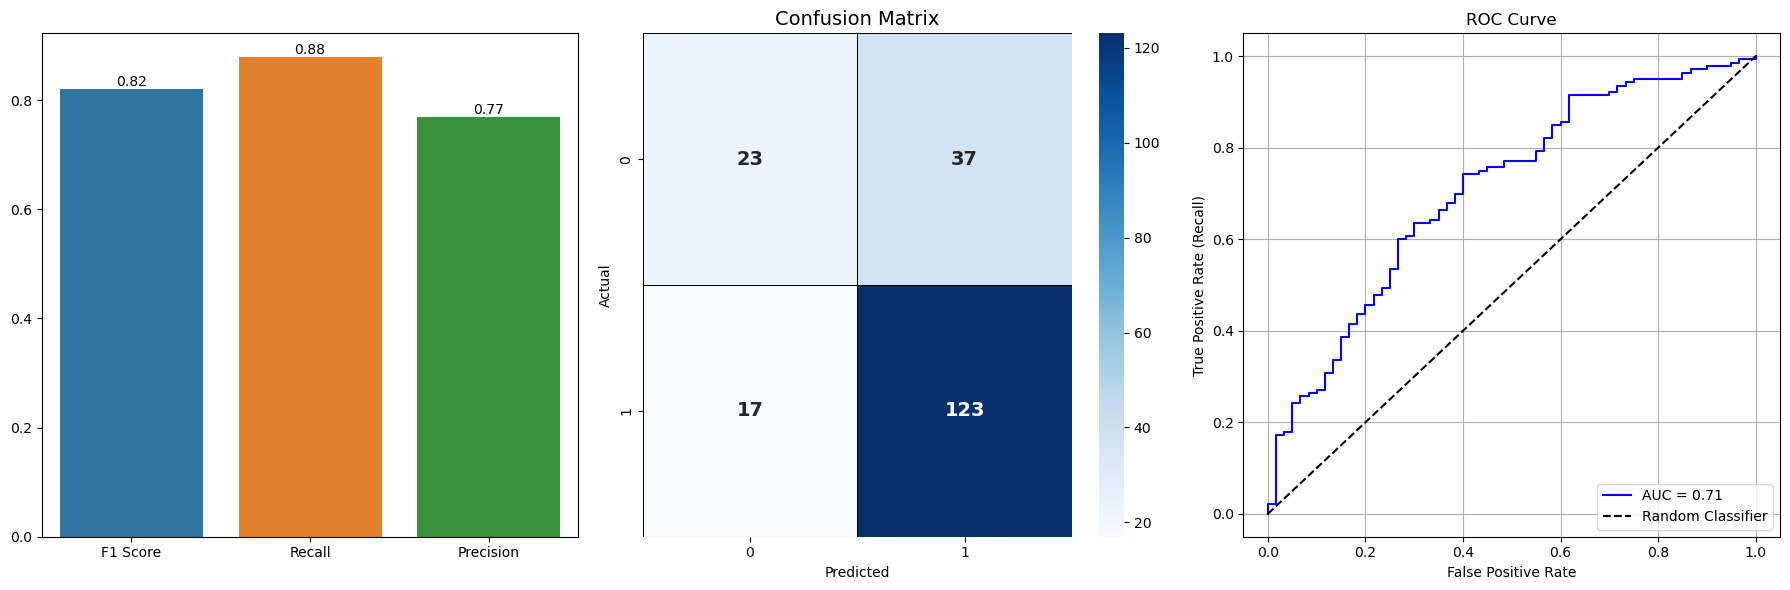




Resultados do modelo:
Pipeline(steps=[('scaler', StandardScaler()), ('near', NearMiss()),
                ('clf',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=30,
                                      weights='distance'))])


c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


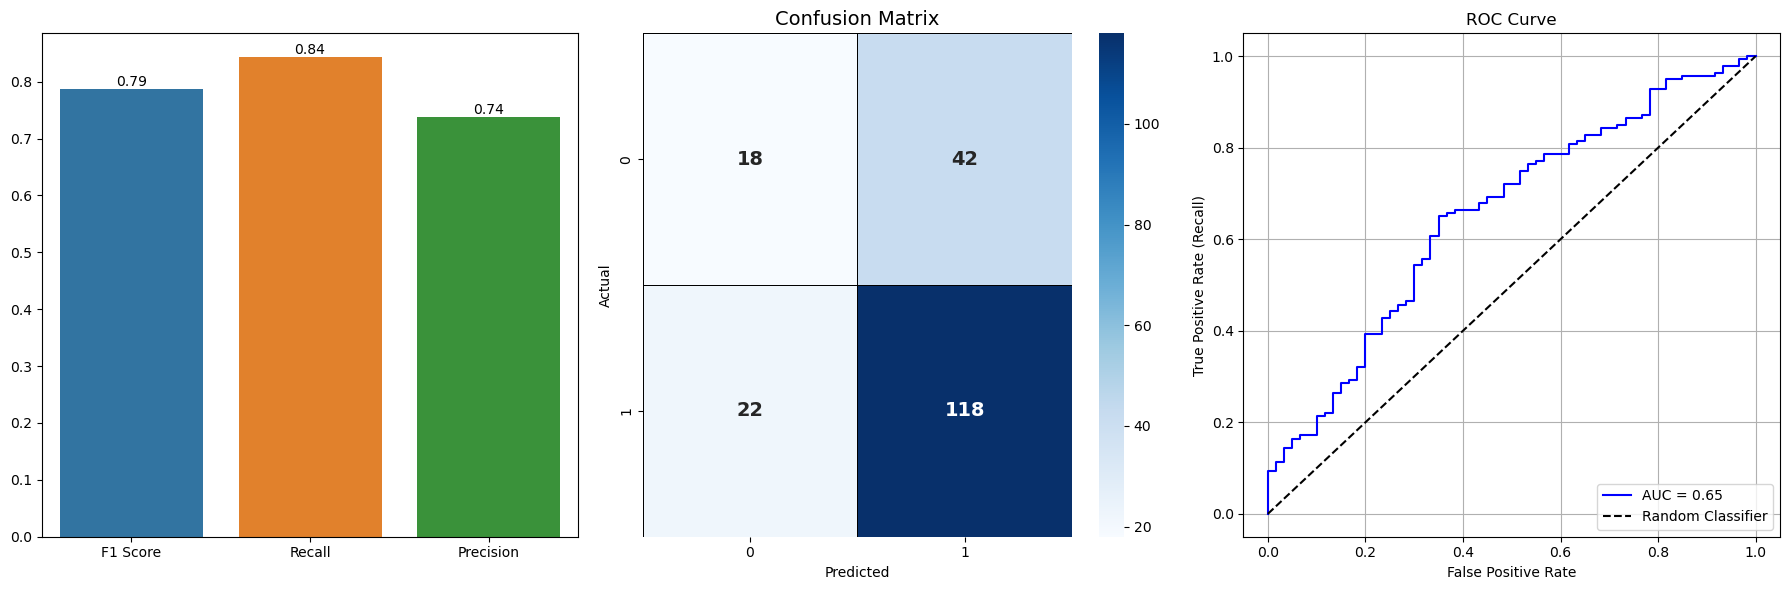

In [26]:
# testar modelo gradient e RF com sample de teste
# Transforma os resultados em DataFrame para facilitar a visualização
results_df = pd.DataFrame(grid_search_st.cv_results_)

# Criar coluna com nome do modelo
results_df['model_name'] = results_df['param_clf'].apply(lambda x: type(x).__name__)

# Encontrar o melhor resultado de cada modelo
best_per_model = results_df.loc[results_df.groupby('model_name')['mean_test_f1'].idxmax()]

# Filtra o melhor RandomForest e gradientBoosting
melhor_rf = best_per_model[best_per_model['model_name'] == "RandomForestClassifier"].iloc[0]
melhor_gb = best_per_model[best_per_model['model_name'] == "GradientBoostingClassifier"].iloc[0]

# Seleciona os parâmetros
params_rf = melhor_rf['params']
params_gb = melhor_gb['params']

# Instancia o modelo com os melhores hiperparâmetros
rf_model = RandomForestClassifier(random_state=42, **{k.split('__')[1]: v for k, v in params_rf.items() if '__' in k})
gb_model = GradientBoostingClassifier(**{k.split('__')[1]: v for k, v in params_gb.items() if '__' in k})
knn_model = grid_search_nm.best_estimator_

models = [rf_model,gb_model,knn_model]

for model in models:
    print("Resultados do modelo:")
    print(model)

    # Treinando os modelos
    model.fit(X_train, y_train)

    # Testa com dados de teste
    y_pred = model.predict(X_test)

    # Calcula metricas
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Cria dataframe com as metricas para plotar o grafico
    data_model = {'F1 Score':f1, 'Recall':recall, 'Precision':precision}
    df_model = pd.DataFrame(data=data_model, index=[0, 1, 2])
    
    
    # Plotando os graficos comparativos
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Grafico de barras
    sns.barplot(data=df_model, ax=axes[0])

    # Adicionando os valores sobre as barras 
    for p in axes[0].patches:
        height = p.get_height()
        axes[0].annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom')

    # Calculando matriz confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # plotando matriz confusão
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                linewidths = 0.5, linecolor='black', annot_kws={"size":14, "weight":"bold"}, ax = axes[1])

    axes[1].set_title('Confusion Matrix', fontsize=14)
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    #verifica modelo 
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        # Calcula curva roc
        roc_auc = roc_auc_score(y_test, y_proba)

        fpr, tpr, thresholds = roc_curve(y_test, y_proba)

        # Plotar curva rOc
        axes[2].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
        axes[2].plot([0, 1], [0, 1], 'k--', label='Random Classifier')

        axes[2].set_xlabel('False Positive Rate')
        axes[2].set_ylabel('True Positive Rate (Recall)')
        axes[2].set_title('ROC Curve')
        axes[2].legend(loc='lower right')
        axes[2].grid(True)

        plt.tight_layout()
        plt.show()
    print("\n\n")

### Conclusão

Os dois modelos que fizeram uso do SMOTE apresentam bons valores, porem também apresentam valores muito proximos.

Já o modelo KNN apresentauma queda nos valroes das metricas colocando-o bem abaixo dos outros dois modelos com um F1 de 0.79, comparado a um empate de 0.82. E um Recall 4% menor do que o gradient boosting, mostrando ser o modelo menos eficiente entre os 3. 

Ja o modelo de random forest apresentou uma melhora no seu desempenho do recall

|comparação| Random forest| Gradient boosting|KNN|
|------|-----|-----|-----|
|F1 Score:| 0.82|0.82|0.79|
|Recall:| 0.91|0.88|0.84|
|Precision:| 0.76|0.77|0.74|
|ROC AUC:| 0.74| 0.71|0.65|



Ao compara os repsultados do modelo RF e GB podemos notar que seu F1 score, é basicamente o mesmo.

Porém oa analisarmos mais a fundo podemos ver que as demais metricas apresentadas o modelo RF apresenta melhores resultados, perdendo apenas na precisão por uma margem muito pequena.

Seria ideal testar os modelos em fazendo uso de uma quantidade maior de dados, uma vez que a quantidade reduzida de dados influencia diretamente nas previsões.

Porém, supondo que a amostra de teste seja suficientemente efetiva, a melhor opção entre os modelos seria o modelo de random forest, por ter um recall de 91%, um valor bem maior do que os demais modelos comparados. 
